# provisioning

In [83]:
# ! mkdir -p ~/aiffel/kaggle_kakr_housing
# ! cp -r ~/data/* ~/aiffel/kaggle_kakr_housing
# ! ls ~/aiffel/kaggle_kakr_housing/data  # 디렉토리 내 파일 확인

In [84]:
# !conda install -c conda-forge xgboost=1.4.2
# !conda install -c conda-forge lightgbm=3.3.0 
# !conda install -c conda-forge missingno=0.5.0

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Prepare
- import
- data prepare

In [86]:
import warnings
warnings.filterwarnings("ignore")

import os

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


In [87]:
data_dir = '~/aiffel/kaggle_kakr_housing/data'
train_data_path = os.path.join(data_dir, 'train.csv')
sub_data_path = os.path.join(data_dir, 'test.csv')

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [88]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [89]:
target = 'price'
y = data[target]
data = data.drop(target, axis=1)
assert target not in data.columns

In [90]:
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [91]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<AxesSubplot:>

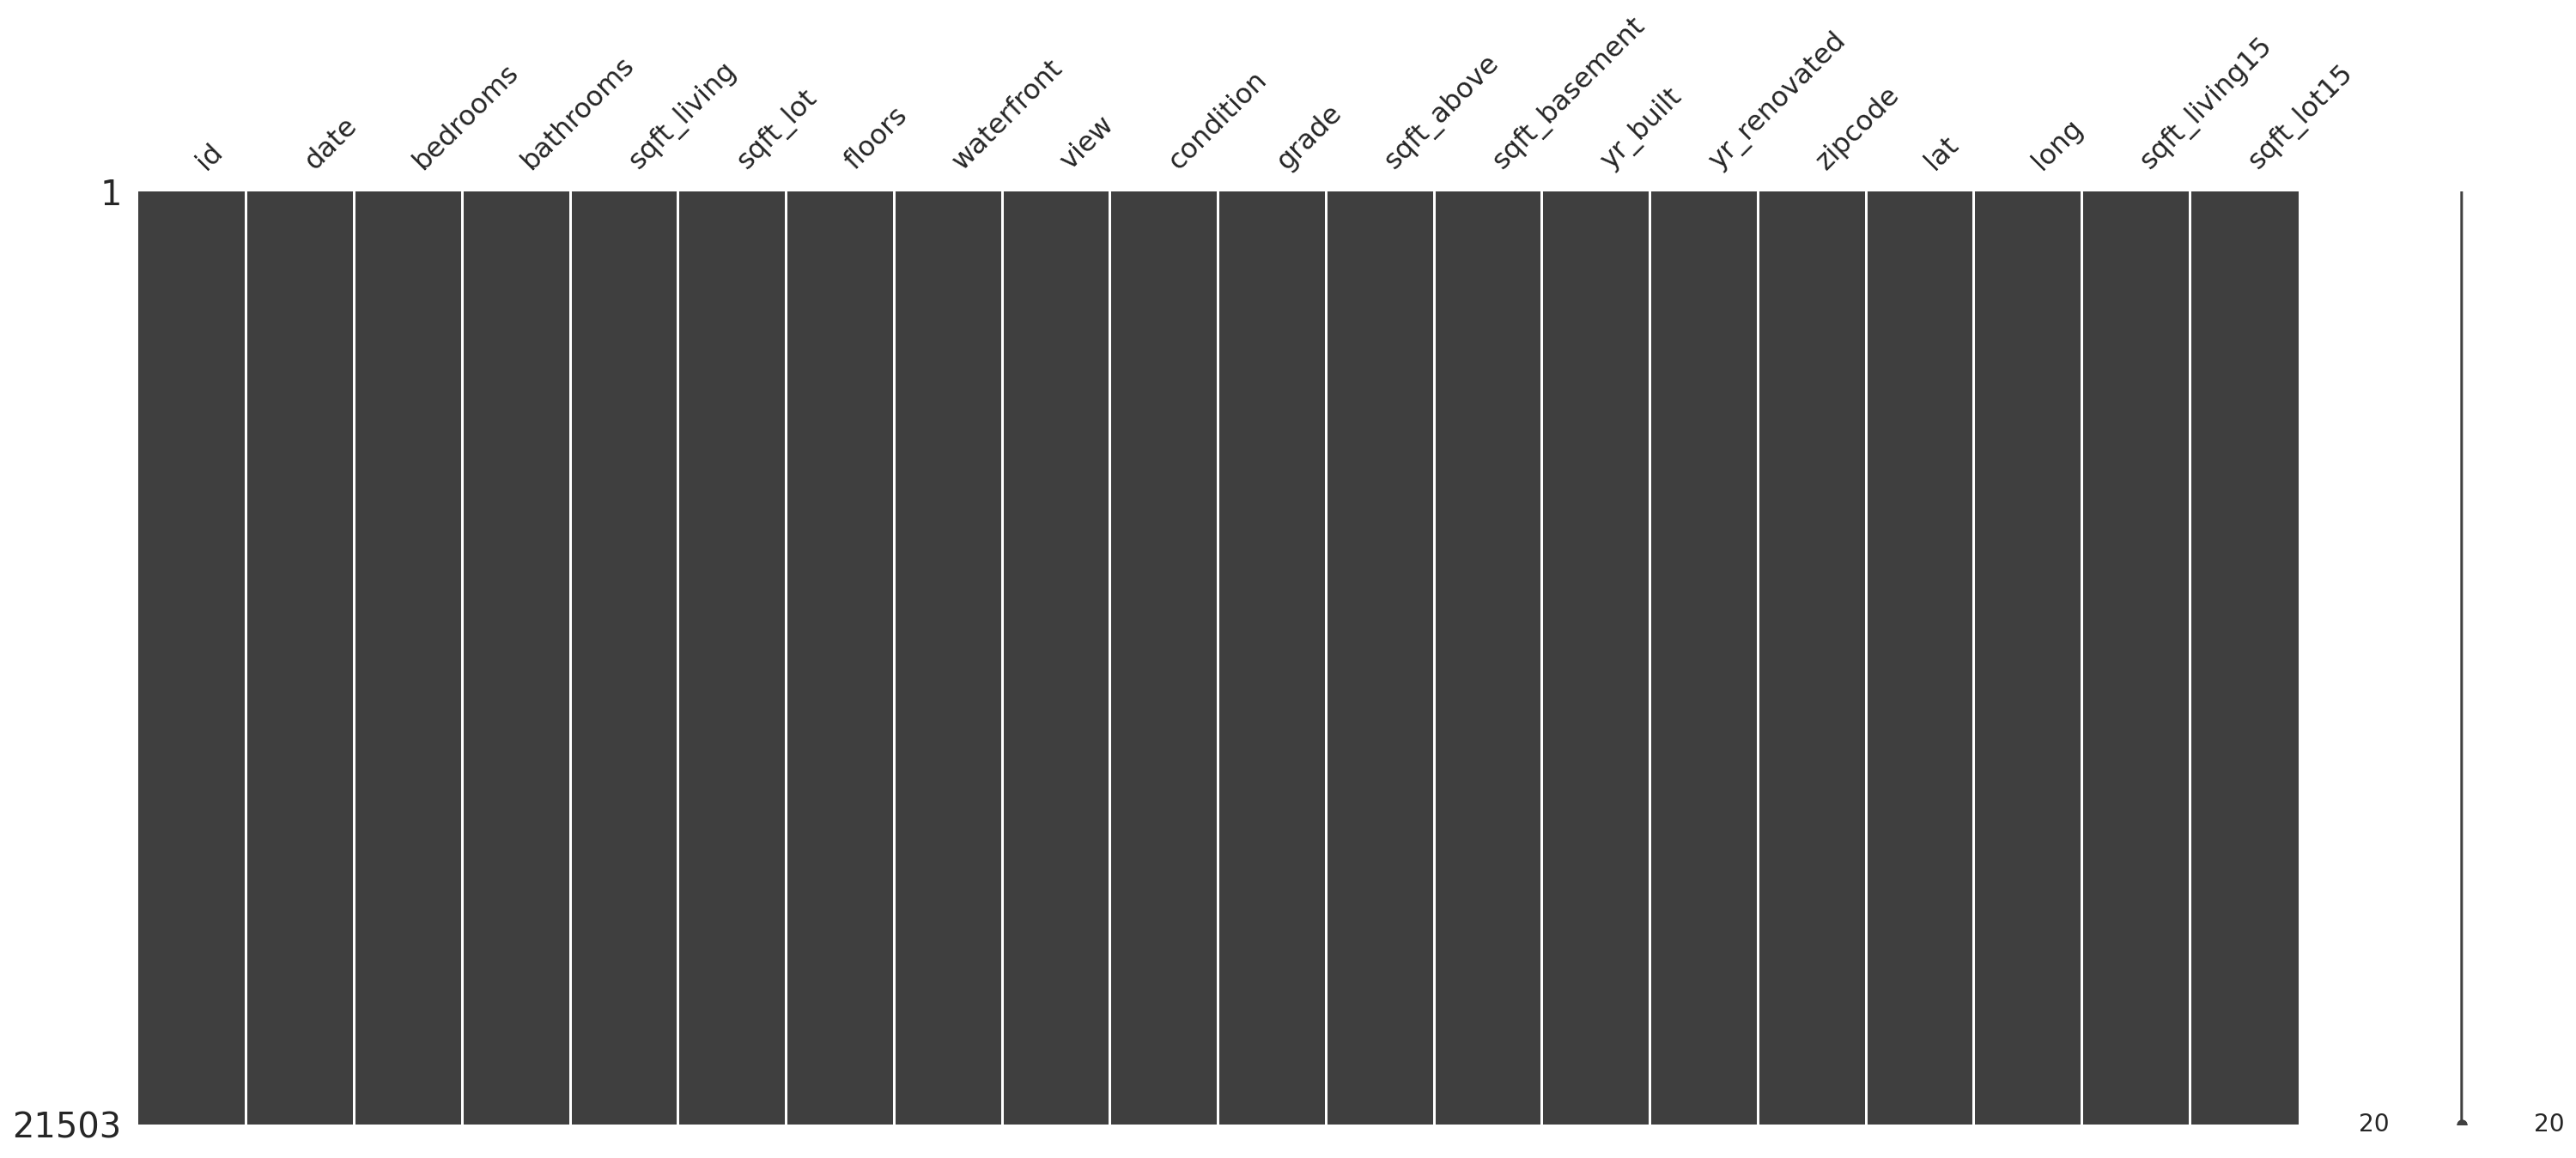

In [92]:
msno.matrix(data)

In [93]:
col_name = 'id'
null_check = pd.isnull(data[col_name])
print(f'{col_name} : {len(data.loc[null_check, col_name].values)}')

id : 0


In [94]:
for col_name in data.columns:
    print(f'{col_name} : {len(data.loc[null_check, col_name].values)}')

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [95]:
sub_id = data['id'][train_len:]
data = data.drop('id', axis=1)
assert 'id' not in data.columns

In [96]:
# 20141013T000000 -> 201410
data['date'] = data['date'].apply(lambda x : str(x[:6]))

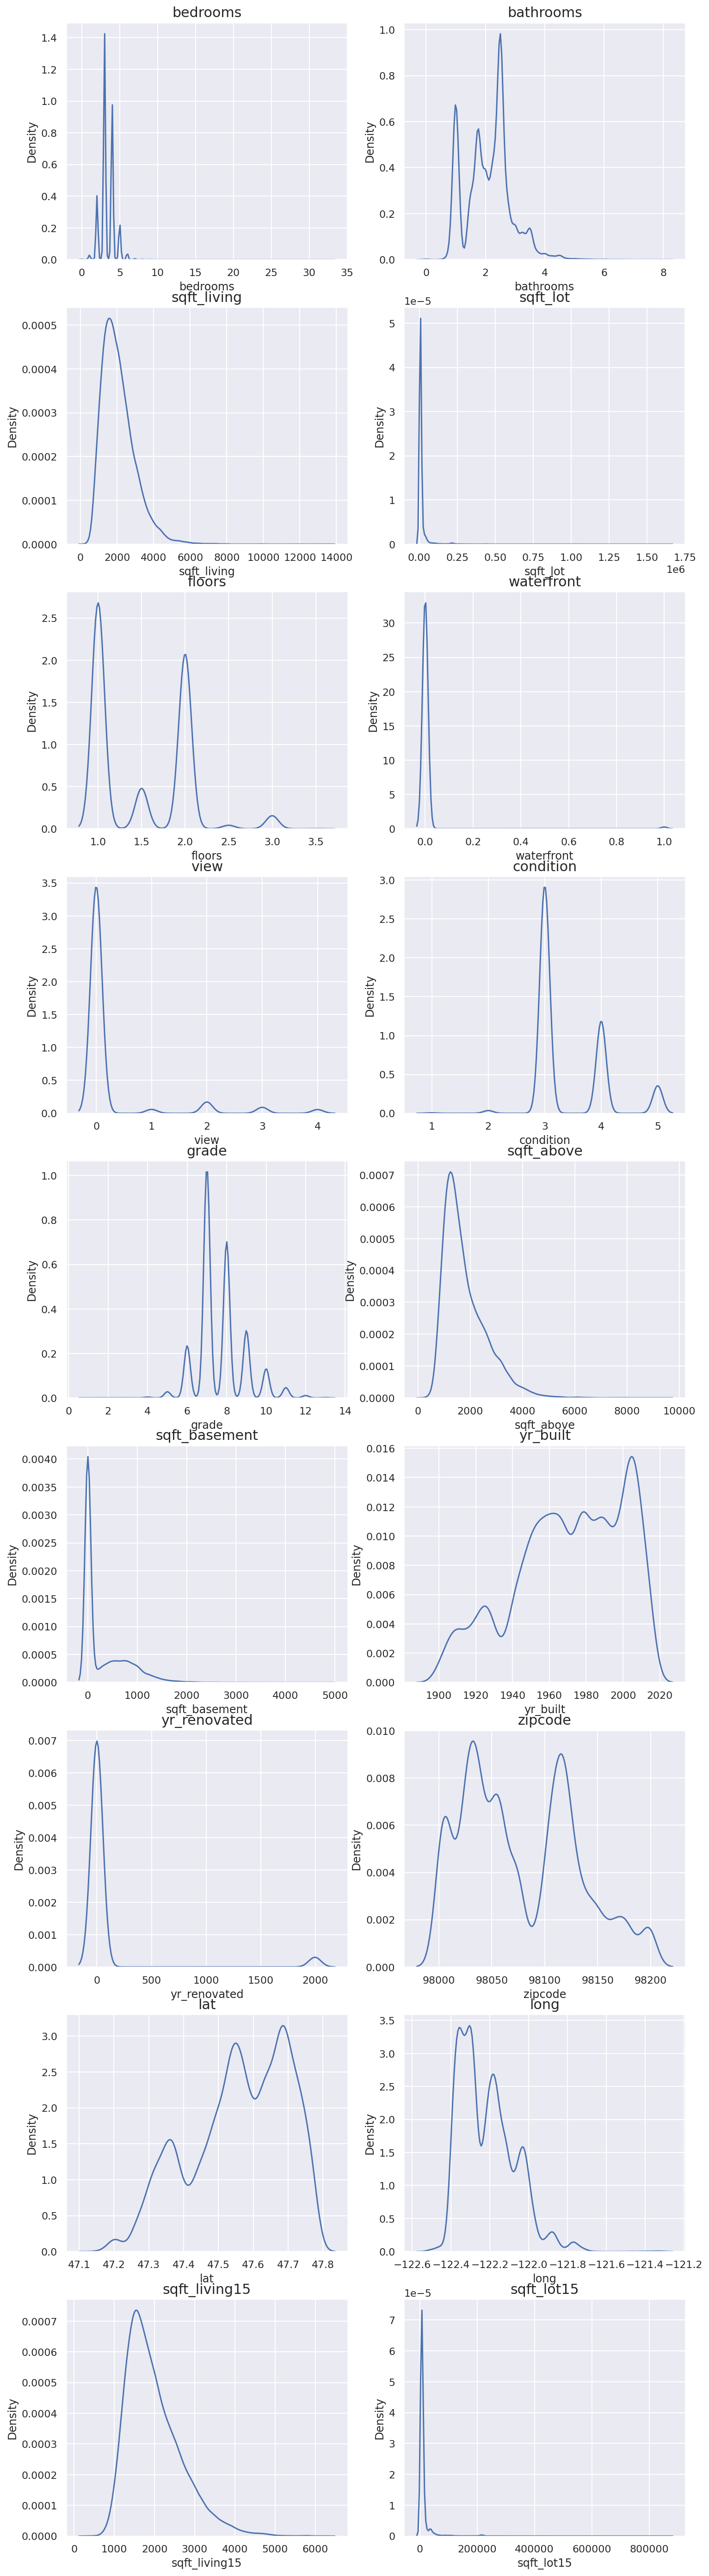

In [97]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [98]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

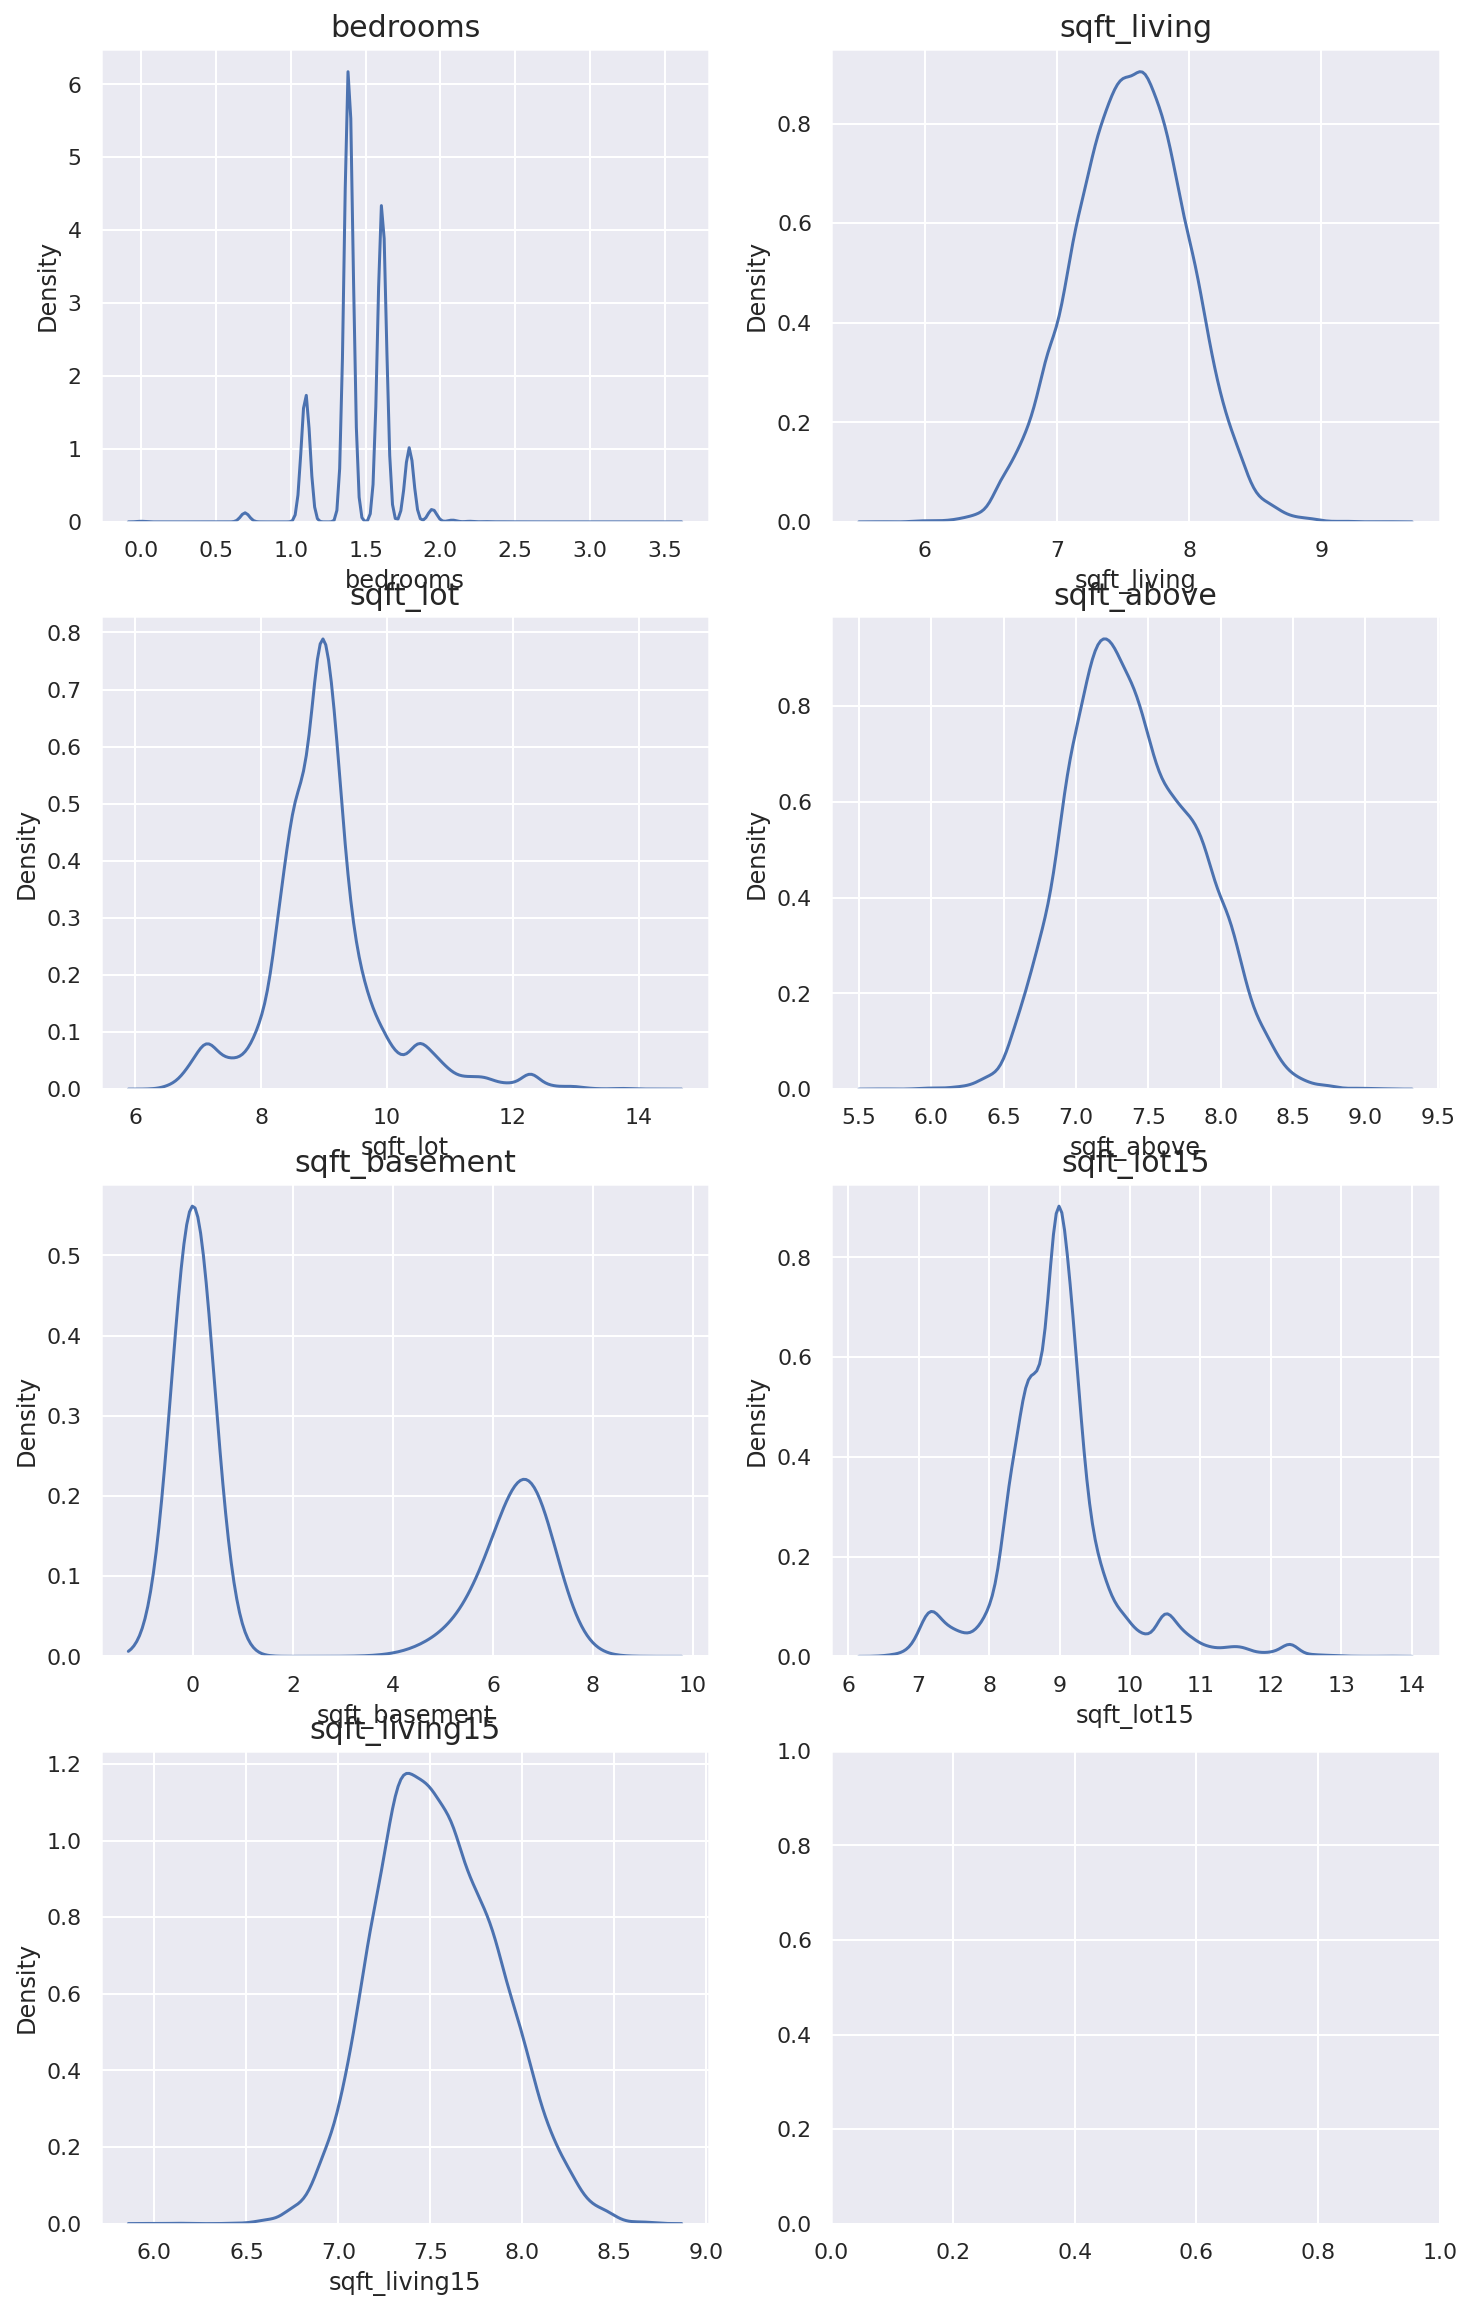

In [99]:
fig, ax = plt.subplots(4, 2, figsize=(12, 20))
for i, col_name in enumerate(skew_columns):
    col = i // 2
    row = i % 2
    cur_ax=ax[col][row]

    sns.kdeplot(data=data[col_name], ax=cur_ax)
    cur_ax.set_title(col_name, fontsize=15)

## log vs log1p
> 설명이 이상하다.

lms에서는 아래와 같이 설명한다.


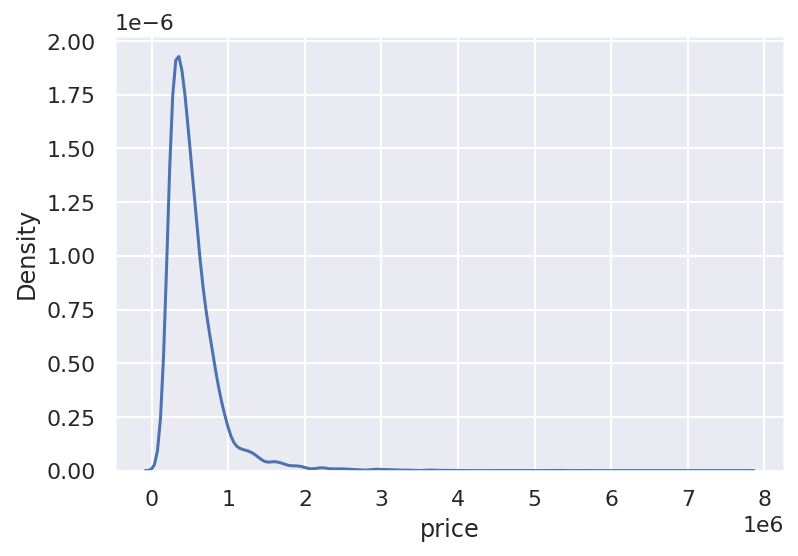

In [100]:
sns.kdeplot(y)
plt.show()

- 위 분포는 0 쪽으로 매우 심하게 치우쳐져 있는 분포를 보인다.
- 즉, 0과 1000000 사이에 대부분의 값들이 몰려있고, 아주 소수의 집들이 굉장히 높은 가격을 보인다.
- 따라서 이 분포에 로그 변환을 취하면, 0에 가깝게 몰려있는 데이터들은 넓게 퍼질 것이고, 매우 크게 퍼져있는 소수의 데이터들은 작은 y값으로 모일 것이다.
- 즉, 왼쪽으로 치우친 값들은 보다 넓은 범위로 고르게 퍼지고 오른쪽으로 얇고 넓게 퍼진 값들은 보다 작은 범위로 모이게 되므로 전체 분포는 정규분포의 형상을 띄는 방향으로 변환될 것이다.

직접 확인해봅시다!

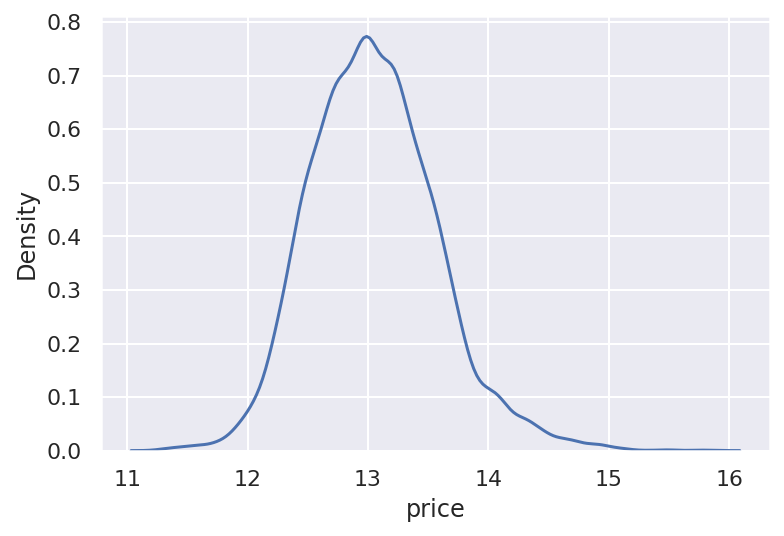

In [101]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

- 확실히 아름다운 정규분포의 모양으로 가까워진 것으로 보입니다!

라고 말하는데 이 설명은 완전히 틀렸다. 왜냐하면 log1p를 사용하고 있기 때문이다.

#### 반박
x>0인 데이터 집합에서 log(x)와 log(1+x)의 분산의 큰차이 점은 0<x<1에서의 로그 함수의 가파른 구간이 log1p에서는 효과가 사라진다. 그런데 lms는 데이터가 0~1사이에 많이 밀집해 있어서, 쭉 펴질 것이라고 한다. 그런데 log1p로 그걸 보여줬으니 틀린 설명이다.

단위가 0-1사이라고 하는 것도 틀렸다. 1e6단위로 구성된 plot이기 때문이다. 
0 ~ 1000000 값들이 많은 거였기 때문에, 0~1같은 거의 없다. 즉 log1p를 통해서 그래프가 완만해진 이유는, 그냥 price가 log를 통과해서 값들 사이의 편차가 줄었기 때문이다.

> log(x)의 경우에는 0-1사이 값을 처리하기 때문에, 0과 1사이에 밀도가 높을 경우, 매우 넓은 범위로 이를 퍼뜨릴 수 있지만, log1p 즉 log(1+x)의 경우에는 log그래프의 0-1사이값들을 모두 무시해버리는 결과를 낳기 때문에 0주변에 몰려 있을 때, 넓게 퍼뜨리는 효과는 없어진다. 왜냐하면 log그래프에서 x> 1의 경우 매우 완만하게 y값이 증가하기 때문에 매우 적은 y 분포로 퍼뜨리는 효과는 없을 것이다.




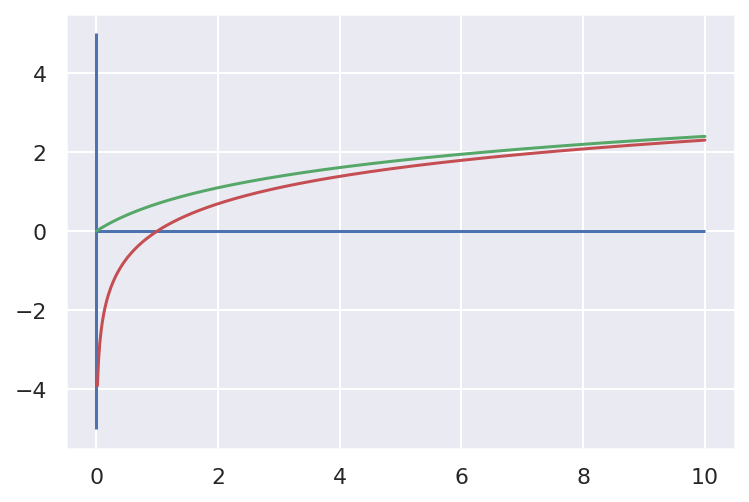

In [102]:
# 실제로 log1p는 0~1사이의 급격한 변화가 없어진다.
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.plot(xx, np.log1p(xx), c='g')
plt.show()

실제로 테스트 해봐도, log1p는 logp에 비하여, 0~1사이값 펴지는 현상이 없기 때문에 상대적으로 모이는 분포가 나온다.

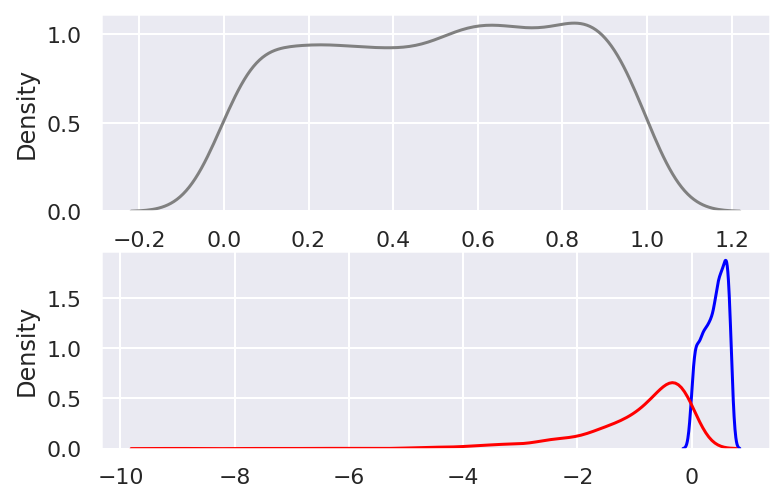

In [103]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 데이터 생성 (임의의 데이터, 0~1 범위)
y = np.random.rand(1000)

fig, ax = plt.subplots(2)


sns.kdeplot(y, color='gray', ax=ax[0], label='Original')

# 원래 데이터의 KDE 플롯 그리기
sns.kdeplot(np.log1p(y), color='blue', ax=ax[1], label='log1p')
sns.kdeplot(np.log(y), color='red', ax=ax[1], label='log')

plt.show()


## Model

In [104]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## 앙상블

> `블렌딩`(앙상블)이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법

- [link](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.)

### 1. Voting
> classification
- voting (weight 모두 동일, hard voting) = 그냥 다수결
- weighted voting (=soft voting)

### 2. Averaging
> regression
- averaging(weight 모두 동일)
- weighted averaging

### 3. Bagging
> Bootstrap Aggregating

- 평균을 통해 분산(variance)값을 줄여 모델을 더 일반화시킨다
- 배깅의 대표적인 알고리즘은 랜덤 포레스트(Random Forest) 입니다


```
1. 일정 수의 base model을 만듭니다.
2. 모델들의 알고리즘은 모두 같습니다.
3. 각각의 모델은 훈련데이터셋에서 랜덤으로 만든 서브 데이터셋을 각각 사용합니다.

* 3에서 서브 데이터셋을 만드는 과정을 부트스트래핑(Bootstrapping) 분할 방식 
* 각각의 서브 데이터셋은 중첩이 가능합니다
```

#### Random Forest
> Bagging

- Decision Tree를 사용해 soft voting을 통해 결정
- feature를 랜덤으로 선택하여 ㅠㅁㅎ햐ㅜㅎ


### 4. Boosting
> 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하며 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식

계속해서 분류기에게 가중치를 부스팅하면서 학습을 진행하기에 부스팅 방식으로 불립니다.

#### 4-1. Ada
> Adaptive boosting

- 잘못 분류한 데이터에 가중치를 부여하여, 다음 분류기는 이를 더 잘 분류하게 만드는 것입니다.
- 오류 데이터에 가중치를 부여하기 때문에 이상치(outlier)에 민감

#### 4-2. Gradient Boost

- Gradient Descent로 가중치를 업데이트함
- Ada와 가중치 업데이트 방식만 다름
- 순차적인 진행때문에 병렬 수행이 불가

#### 4-3. XGBoost (+ Light도 있음)
> XGBoost(eXtra Gradient Boost)

- XGBoost는 GBM보다는 빠르지만 여전히 느린 알고리즘입니다
- 병렬 CPU를 이용하여 GBM보다 빠른 수행을 합니다. 

### 5. Stacking

가장 핵심 아이디어는 머신러닝 알고리즘으로 훈련 데이터셋을 통해 새로운 데이터셋을 만들고, 이를 데이터셋으로 사용하여 다시 머신러닝 알고리즘을 돌리는 것입니다. 보통은 서로 다른 타입의 모델들 을 결합합니다.


2가지 모델이 필요합니다.

1. 개별적인 기반 모델 : 성능이 비슷한 여러 개의 모델
2. 최종 메타 모델 : 기반 모델이 만든 예측 데이터를 학습 데이터로 사용할 최종 모델

### 6. Blending

stacking과 유사한데, cross-fold-validation 사용하는 stacking과 달리 holdout validation을 사용하여 정보누설 줄임



# Kaggle Ensembling Guide (MLWave) / Part. 1 - (Averaging)
> https://jamm-notnull.tistory.com/16#google_vignette

- 여러 번 코드가 반복될 수록 에러 수정 능력이 증가합니다

```
우리가 10개의 샘플을 가지고 있다고 가정합시다. 이 샘플들의 정답(ground truth)은 모두 1입니다. 

1111111111

그리고 우리는 세 개의 이진 분류기 (binary classifiers) 들이 있습니다. 각각의 모델은 70%의 정확도를 가지고 있습니다. 이 세 개의 분류기를 70%확률로 1을 뱉고, 30%의 확률로 0을 뱉는 난수 생성기로 볼 수도 있습니다. 이러한 랜덤 모델들도 다수결 투표 방법으로 78%의 정확도를 가지도록 할 수 있습니다. 약간의 수학을 더하자면 : 

3명의 다수결 투표 방식으로는 4가지의 결과값을 기대할 수 있습니다.

세개 모두 정답 : 0.7 * 0.7 * 0.7 = 0.3429

두개만 정답 :  0.7 * 0.7 * 0.3 + 0.7 * 0.3 * 0.7 + 0.3 * 0.7 * 0.7 = 0.4409

한개만 정답 : 0.3 * 0.3 * 0.7 + 0.3 * 0.7 * 0.3 + 0.7 * 0.3 * 0.3 = 0.189

셋 다 틀림 : 0.3 * 0.3 * 0.3 = 0.027

우리는 여기서 약 44%라는 많은 경우에 대해서 다수결 투표가 오답을 정답으로 고칠 수 있는 것을 알 수 있습니다. 이러한 투표는 정답률을 78%까지 올려줍니다. (0.3429 + 0.4409 = 0.7838)
```



In [105]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]


def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

get_cv_score(models)        

ValueError: Found input variables with inconsistent numbers of samples: [15035, 1000]

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [ ]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = os.path.join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

my_submission_path = os.path.join(data_dir, 'submission.csv')

result.to_csv(my_submission_path)
print(my_submission_path)

## 모델 조작하기

In [ ]:
from os.path import join

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)


In [ ]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
y = train['price']
del train['price']

del train['id']

In [ ]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']
print(test.columns)

In [ ]:
sns.kdeplot(y)

In [ ]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [ ]:
train.info()

## Metric

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
random_state=2024

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
gboost.__class__.__name__

In [ ]:
# df = {}

# for model in models:
#     # 모델 이름 획득
#     model_name = model.__class__.__name__

#     # train, test 데이터셋 분리
#     # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
#     X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

#     # 모델 학습
#     model.fit(X_train, y_train)
    
    
#     # 예측
#     pred = model.predict(X_test)

#     # 예측 결과의 rmse값 저장
#     df[model_name] = rmse(y_test, pred)
    
#     # data frame에 저장
#     score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
# df

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [ ]:
from sklearn.model_selection import GridSearchCV

## 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색합니다. 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리하겠네요!

랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법입니다.

그리드 탐색에서는 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있는 반면, 랜덤 탐색에서는 말 그대로 랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 언제나 열려 있습니다. 하지만 그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는다는 보장은 없어요.


```
param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)

scoring : 모델의 성능을 평가할 지표

cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수

verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)

n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수
```

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}
model = LGBMRegressor(random_state=random_state)

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

위에 출력된 메세지에 나타난 'totalling 20 fits' 에서 20은 어떻게 계산된 값일까요?

> 위에서 우리가 입력한 param_grid에 n_estimators 두 가지, max_depth 두 가지를 넣었으므로 가능한 조합은 총 2 × 2 = 4가지입니다.
또한, cross validation은 각 경우마다 5번을 진행하니 총 20 fits를 진행하게 됩니다.
여기에서 cross validation을 5번 진행하는 이유는, 각 조합에 대해 단 한 번만 실험을 하는 것보다 5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문입니다. 간단하게, 한 번만 해 보는 것보다는 다섯 번을 해보고 구한 평균값이 더 정확하겠죠!

In [ ]:
grid_model.cv_results_

In [ ]:
params = grid_model.cv_results_['params']
params

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

In [ ]:
results = pd.DataFrame(params)
results['score'] = score

In [ ]:
results

In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

앗, 하지만 아직도 위에서 보았던 10만 단위의 RMSE와는 값의 크기가 아주 다른 것 같습니다.

그 이유는 price에 있습니다. 위에서 우리는 price의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log 변환을 했었죠.
그 후 RMSE 값을 계산하기 위한 함수에서는 np.expm1 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산했습니다.

하지만 그리드 탐색을 하면서는 np.expm1()으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 price 데이터에서 손실함수값을 계산한 것이죠.
따라서 사실, 위의 데이터 프레임에 나타난 값은 정확히 말하면 RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error 입니다.
log를 취한 값에서 RMSE를 구했다는 뜻이죠!

이에 맞게 컬럼의 이름을 RMSLE로 변환해 주도록 하겠습니다. 판다스에서 컬럼의 이름 변환은 rename으로 할 수 있습니다.

In [ ]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

In [ ]:
results.sort_values('RMSLE')

In [ ]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

In [ ]:
prediction = np.expm1(prediction)
prediction

In [ ]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

# Kaggle upload 용

-------

- https://www.kaggle.com/code/hongseoi/eda-ml-on-housing-price

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import math

from sklearn.preprocessing import RobustScaler
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
import seaborn as sns

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

origin_train = pd.read_csv(join(data_dir, 'train.csv'))
origin_test = pd.read_csv(join(data_dir, 'test.csv') )

train, test = origin_train.copy(), origin_test.copy()

In [ ]:
train_len = len(train)
sub_id = train['id'][train_len:]

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

In [ ]:
def check_missing(data):
    msno.matrix(data)
    for c in data.columns:
        print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

df = pd.concat((train, test), axis=0)
check_missing(df)

In [ ]:
def check_distribution(df, col=1):
    row = int(df.shape[1] / col)

    count = 1
    columns = df.columns
    
    fig, ax = plt.subplots(row, col, figsize=(12,20))
    for i in range(row):
        for j in range(col):
            sns.kdeplot(data=df[columns[count]], ax=ax[i][j])
            ax[i][j].set_title(columns[count], fontsize=15)
            count += 1
            if count == df.shape[1]:
                break
    plt.subplots_adjust(wspace=0.5, hspace=1)
                
check_distribution(df, col=2)

In [ ]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

def log_scaling(data, skew_columns):
    for c in skew_columns:
        data[c] = np.log1p(data[c].values)
    return data

log_scaling(df, skew_columns)

In [ ]:
check_distribution(df, col=2)

In [ ]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [ ]:
# IQR scale: delete outliers
def robust_scale(df):
    robustscaler = RobustScaler()
    robustscaler.fit(df)

    df = robustscaler.transform(df) 
    return df
robust_scale(df)

In [ ]:
check_distribution(df, col=2)

In [ ]:
# coefficient
# price 상관관계확인을 위해, origin_train 사용

fig = plt.figure(figsize = (10, 8))
ax = fig.gca()


cor_abs = abs(origin_train.corr(method='spearman')) 

cor_cols = cor_abs.nlargest(n=10, columns='price').index
columns = cor_cols.values

print(columns)

sns.set()
corr = origin_train[columns].corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True,
                      yticklabels=columns, 
                      xticklabels=columns,
                      ax=ax, cmap="RdYlBu")
plt.tight_layout()
plt.show()

In [ ]:
train, test = df[:len(train)], df[len(train):]
print(train.shape)
print(test.shape)
print(len(y))
train.info()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# def get_gs_result(
#     model, train, y, param_grid={'n_estimators': [50, 100], 'max_depth': [1, 10] }, verbose=2, n_jobs=5):
    
#     grid_model = GridSearchCV(
#         model, param_grid=param_grid, 
#         scoring='neg_mean_squared_error', 
#         cv=5, verbose=verbose, n_jobs=n_jobs)
    
#     grid_model.fit(train, y)

#     params = grid_model.cv_results_['params']
#     score = grid_model.cv_results_['mean_test_score']
    
#     results = pd.DataFrame(params)
#     results['score'] = score
    
#     results['RMSLE'] = np.sqrt(-1 * results['score'])
#     results = results.sort_values('RMSLE')

#     return results

# random_state=42
# get_gs_result(
#     LGBMRegressor(random_state=random_state), train, y)

In [ ]:
get_gs_result(
    XGBRegressor(random_state=random_state), train, y)

In [ ]:
get_gs_result(
    RandomForestRegressor(random_state=random_state), train, y)

In [ ]:
get_gs_result(
    GradientBoostingRegressor(random_state=random_state), train, y)

In [ ]:
# ensemble
from sklearn.ensemble import StackingRegressor

def get_stacking_model():
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    gboost = GradientBoostingRegressor(random_state=random_state)
    xgboost = XGBRegressor(random_state=random_state)
    lightgbm = LGBMRegressor(random_state=random_state)
    rdforest = RandomForestRegressor(random_state=random_state)

    stack_models = [
        ('gb', gboost),
        ('xgb', xgboost),
        ('lgbm', lightgbm),
        ('rf', rdforest)
    ]
    
    stack_reg = StackingRegressor(stack_models, final_estimator=gboost)
    stack_reg.fit(X_train, y_train)
    
    y_pred = stack_reg.predict(X_test)
    print(f'rmse: {rmse(y_pred, y_test)}')
    
    return stack_reg

random_state=42
s_model = get_stacking_model()

In [ ]:
# def save_submission(model):
#     prediction = model.predict(test)
#     prediction = np.expm1(prediction)
#     sub = pd.DataFrame(data={'id':sub_id,'price':prediction})
#     sub.to_csv('submission.csv', index=False)
#     print('submission complete!')

def save_submission(model, test):
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission.to_csv('submission.csv', index=False)
    print('submission complete!')
        
    

save_submission(s_model, test)

- 모델 선정이유: stacking이 상대적으로 효과적인 앙상블 모델이라 하여, 적용해보았다.
- metric 선정이유: kaggle 지정
